In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import src.basic_function_cap as bfc
import src.piano_key_notes as pkn
import ipywidgets as widgets
from ipywidgets import interact

# Crop video

In [2]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

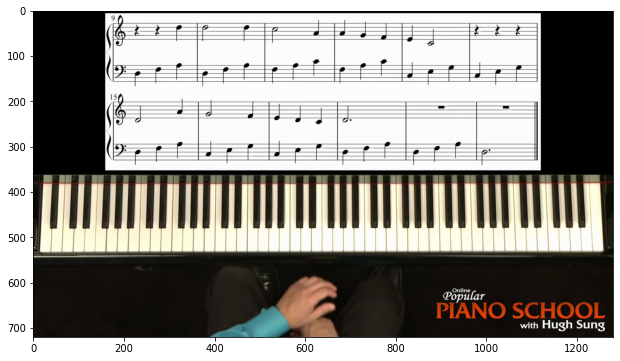

In [3]:
bfc.show_frame(cap, 814)
_, frame = bfc.get_frame(cap, 814)

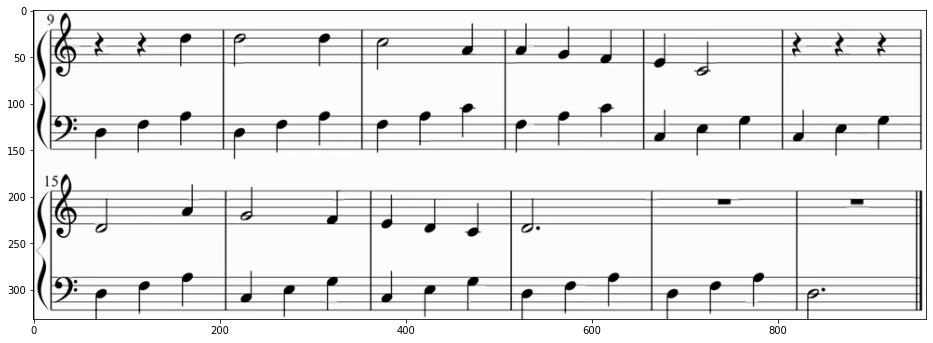

In [4]:
cropped_sheets = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)

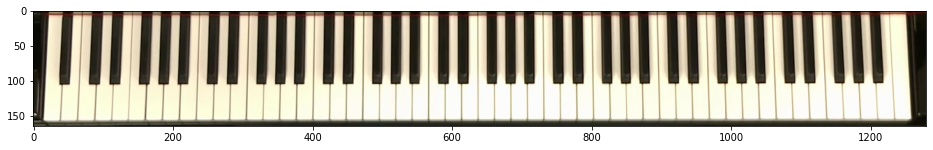

In [5]:
cropped = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=True)

# Get notes

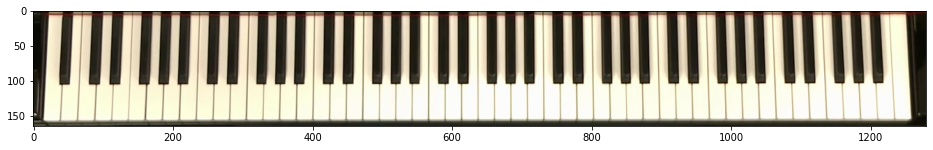

In [6]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
image = bfc.get_frame(cap, 814)[1]
image = bfc.crop_frame(image, 375, 0, 540-375, image.shape[1], show=True)

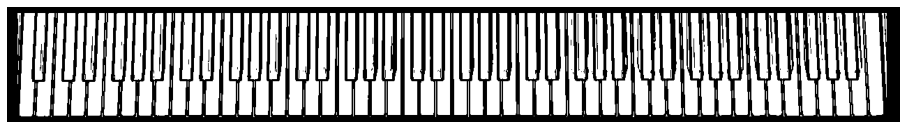

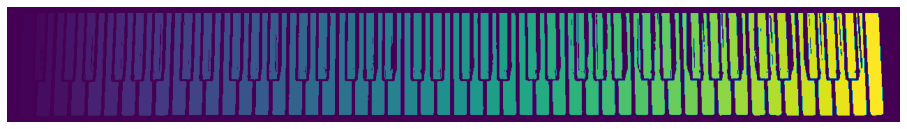

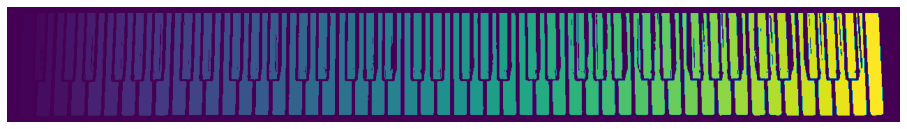

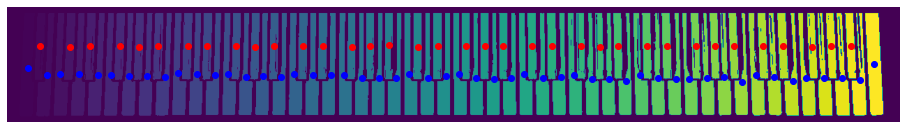

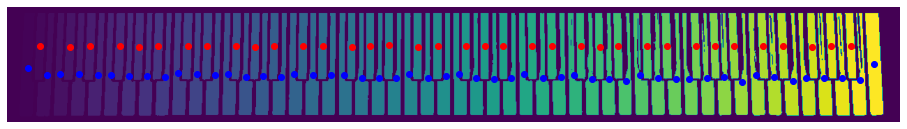

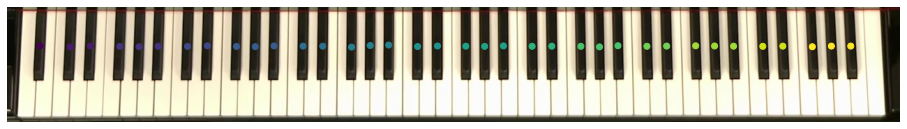

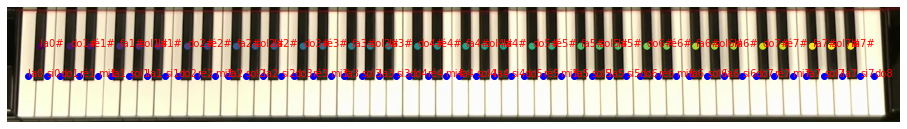

In [7]:
pipe = pkn.pipeline(image, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=True)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

# Hightlight notes from sheet

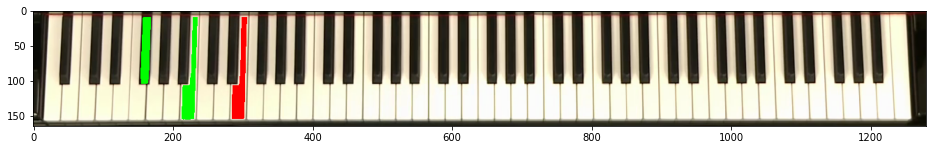

In [8]:
g = [0,255,0]
b = [0,0,255]
r = [255,0,0]
_ = pkn.highlight_keys(image=image, labels=labels, keys = [10,15,20], color = [g,g,r], show=True)

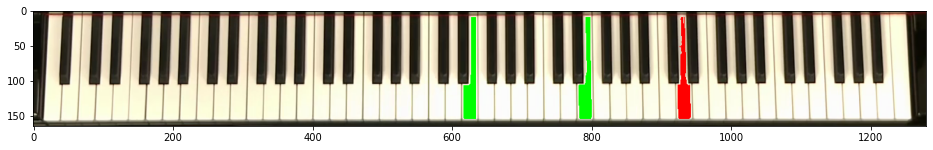

In [9]:
_ = pkn.highlight_notes(image=image, labels=labels, notes = ["mi4", "mi5", "ré6"], dict_notes = notes, color = [g,g,r], show=True)

# Get difference

In [10]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

def show_frame(frame_number, shift):
    _, mask = bfc.get_frame(cap, 219)
    _, frame = bfc.get_frame(cap, 219+frame_number)
    mask = bfc.crop_frame(mask, 330, 0, 540-330, frame.shape[1])
    frame = bfc.crop_frame(frame, 330, 0, 540-330, frame.shape[1])
    plt.figure(figsize=(16,16))
    plt.imshow(frame)
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(frame - mask + shift)
    plt.show()

interact(show_frame,
        frame_number=widgets.IntSlider(min=0, max=32*32-10, step=1, value=100),
        shift=widgets.IntSlider(min=0, max=30, step=1, value=0))

interactive(children=(IntSlider(value=100, description='frame_number', max=1014), IntSlider(value=0, descripti…

<function __main__.show_frame(frame_number, shift)>

In [11]:
def show_frame(key_number):
    pkn.highlight_keys(image=image, labels=labels, keys = key_number, show=True)

interact(show_frame,
        key_number=widgets.IntSlider(min=0, max=n_labels, step=1, value=0))

interactive(children=(IntSlider(value=0, description='key_number', max=89), Output()), _dom_classes=('widget-i…

<function __main__.show_frame(key_number)>

# Read sheet

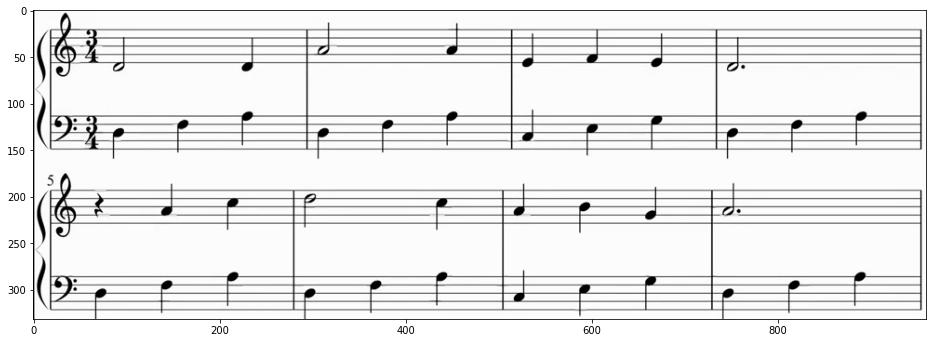

In [12]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)

## Black notes

In [13]:
def dilate_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(dilation)
        plt.show()
    return dilation

def erode_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    erosion = cv2.erode(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(erosion)
        plt.show()
    return erosion

In [14]:
def get_black_notes(img, show = False):

    dilated = dilate_img(img, 8, 6, show = show)
    eroded = erode_img(dilated, 8, 6, show = show)

    gray = np.float32(cv2.cvtColor(eroded,cv2.COLOR_BGR2GRAY))

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel / sobel.max()*255).astype(np.uint8)

    black_white_threshold = 50
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255

    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 15, param1 = 1, param2 = 6,
                                minRadius = 5,
                                maxRadius = 7
                            )
    circles = np.uint16(np.around(circles))
    new_circles = [] 

    img_circles = img.copy()
    for i in range(len(circles[0,:])):
        cv2.circle(img_circles, (circles[0,i,0], circles[0,i,1]), circles[0,i,2], (0,255,0), 2)
        new_circles.append(circles[0,i])
        
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.show()

    return np.array([new_circles])


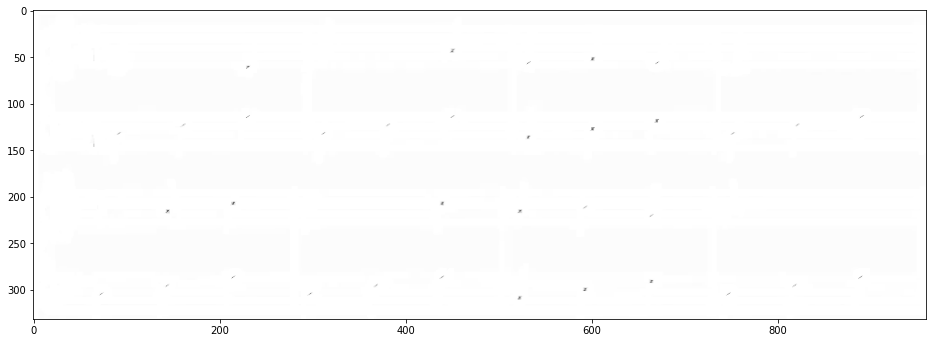

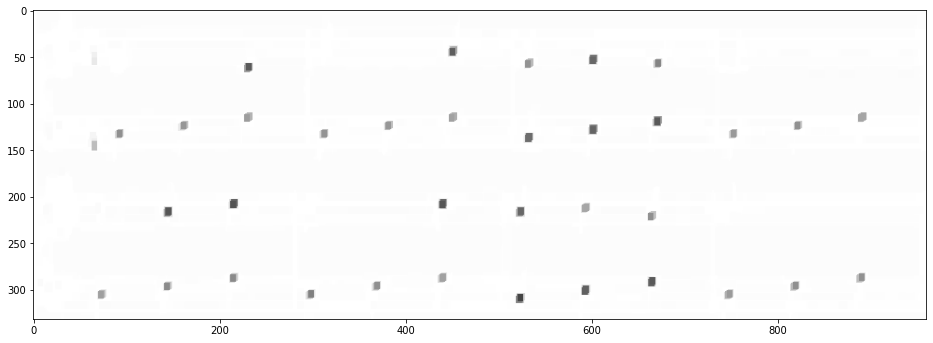

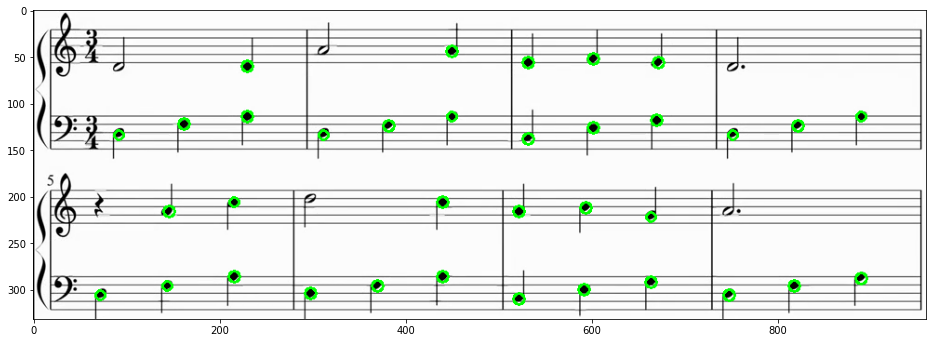

In [15]:
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_ = get_black_notes(img, show=True)

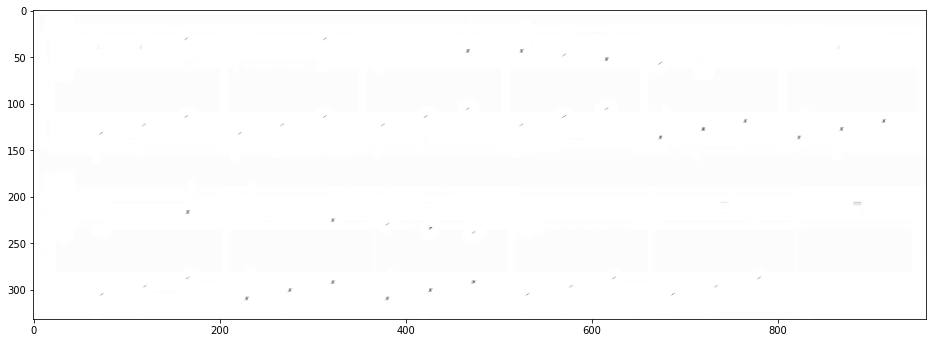

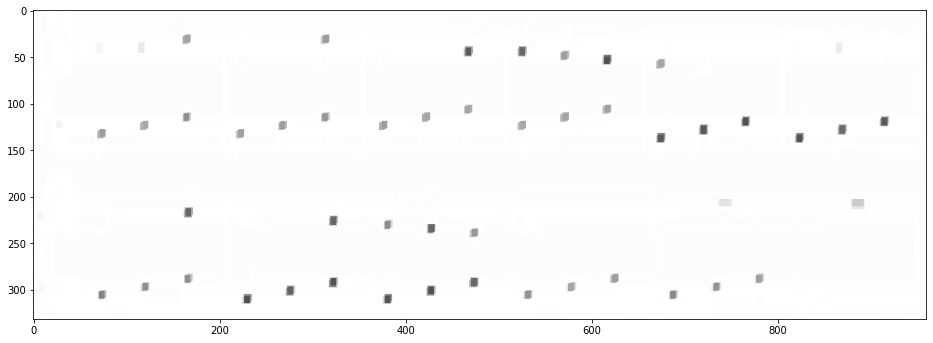

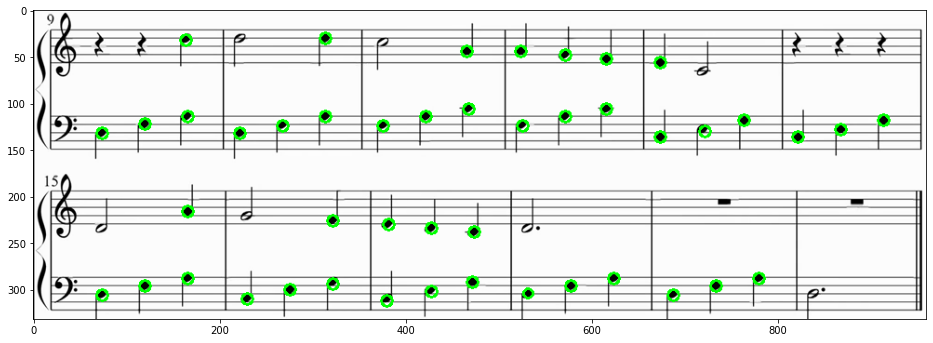

In [16]:
_, frame = bfc.get_frame(cap, 780)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_ = get_black_notes(img, show=True)

## White notes

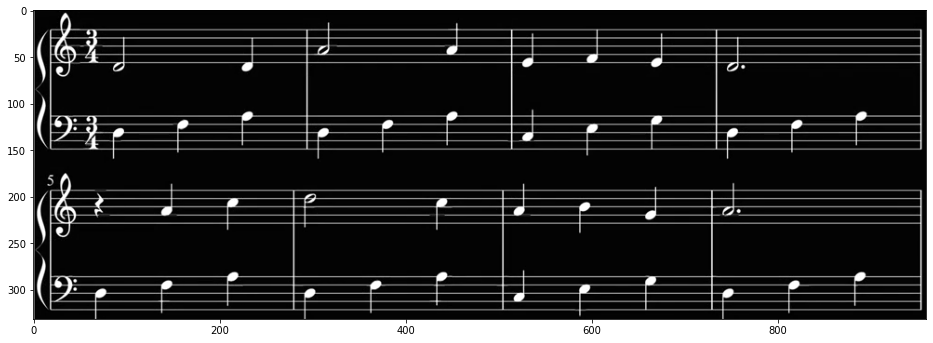

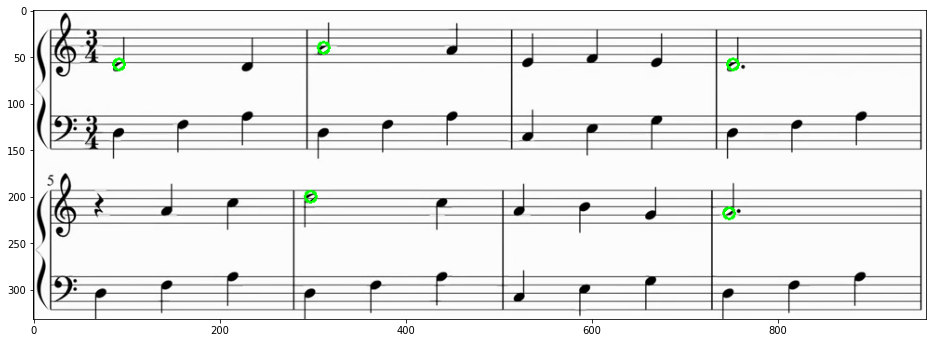

In [17]:
def get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show = False):

    gray = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    inverse = 255 - gray

    circles = cv2.HoughCircles(inverse, cv2.HOUGH_GRADIENT, dp = dp, minDist = minDist, param1 = param1, param2 = param2,
                                minRadius = minRadius,
                                maxRadius = maxRadius
                            )
    circles = np.uint16(np.around(circles))
    new_circles = [] 

    img_circles = img.copy()
    for i in range(len(circles[0,:])):
        if circles[0,i][0] > 70: # remove circles too close to the left
            if max(img[circles[0,i][1]+x, circles[0,i][0]+j, 0] for x in range(-1,2) for j in range(-1,2)) > 200: # if the center of the circle is not black
                cv2.circle(img_circles,(circles[0,i][0],circles[0,i][1]),circles[0,i][2],(0,255,0),2)
                new_circles.append(circles[0,i])

    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(inverse, cmap='gray')
        plt.show()
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.show()

    return np.array([new_circles])

cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_ = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show=True)

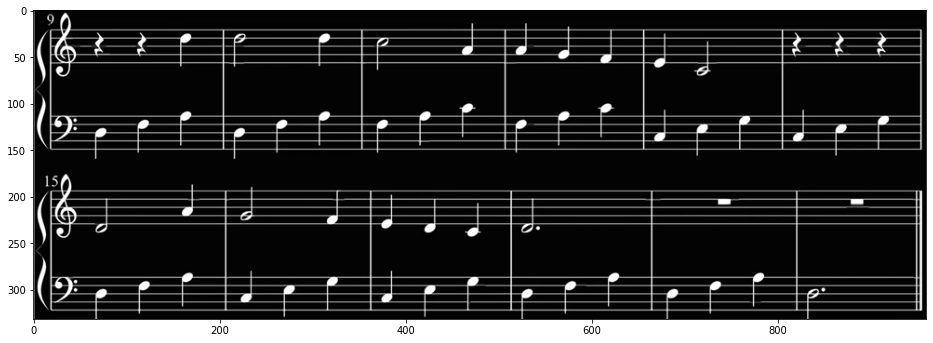

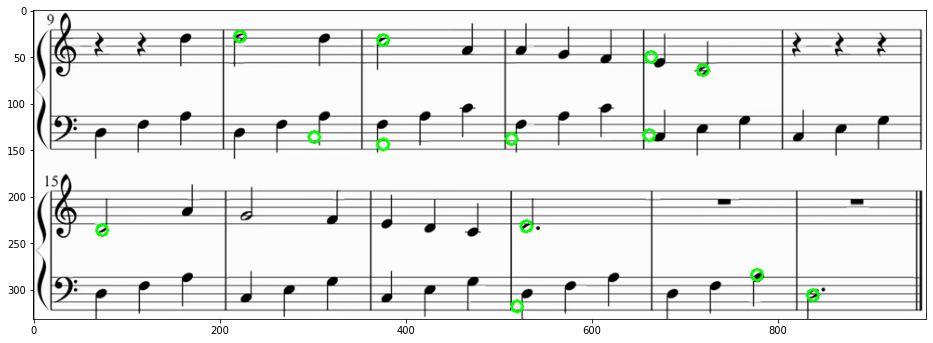

In [18]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 677)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_ = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=6, minRadius=6, maxRadius=7,show=True)

## Combine white and black notes

In [19]:
def min_distance(center, circles):
    if len(circles) == 0:
        return 1000000
    return min(np.sqrt((center[0].astype(int) - circles[:,0].astype(int))**2 + (center[1].astype(int) - circles[:,1].astype(int))**2))

# we want the white_circle to be far enough from all the black circles
def all_notes_circles(img, black_circles, white_circles, min_dist=20, show=False):
    new_white_circles = []
    for i in range(len(white_circles[0])):
        white_circle = white_circles[0,i]
        if min_distance(white_circle, black_circles[0]) > min_dist and min_distance(white_circle, white_circles[0,i+1:]) > min_dist:
            new_white_circles.append(white_circle)
    new_white_circles = np.array([new_white_circles])
    if show:
        img_circles = img.copy()
        for i in new_white_circles[0,:]:
            cv2.circle(img_circles,(i[0],i[1]),i[2],(0,0,255),2)
        for i in black_circles[0,:]:
            cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.show()
    all_circles = np.concatenate((black_circles, new_white_circles), axis=1)
    return all_circles, black_circles, new_white_circles


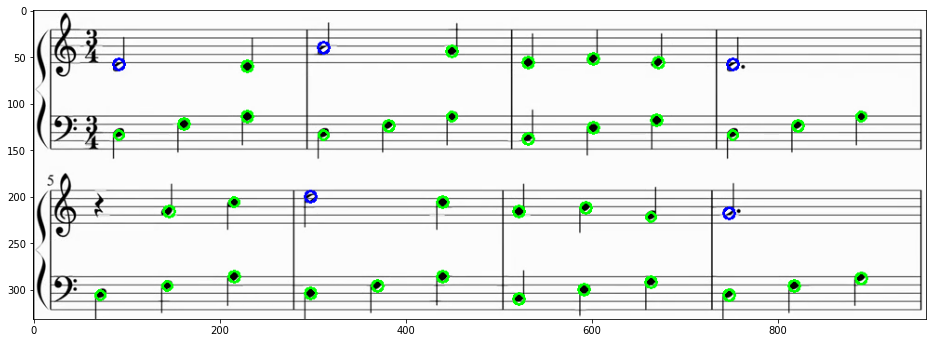

In [20]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
black_circles = get_black_notes(img)
white_circles = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7)
all_circles, black_circles, white_circles = all_notes_circles(img, black_circles, white_circles, min_dist=10, show=True)

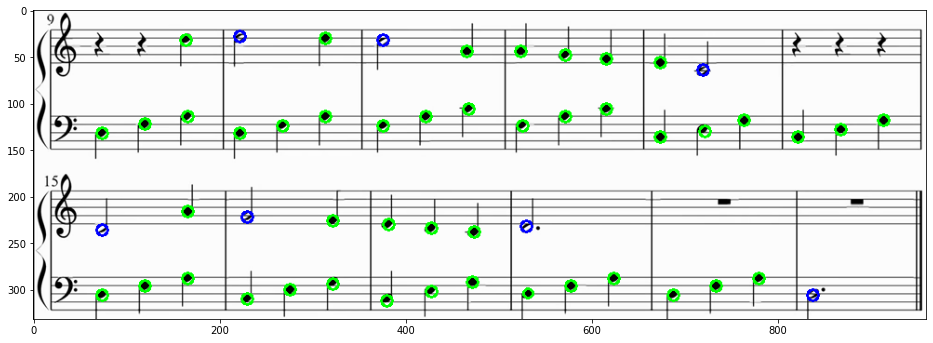

In [21]:
_, frame = bfc.get_frame(cap, 781)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
black_circles = get_black_notes(img)

_, frame = bfc.get_frame(cap, 677)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
white_circles1 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=6, minRadius=6, maxRadius=7)
white_circles2 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7)
white_circles = np.concatenate((white_circles1, white_circles2), axis=1)

all_circles, black_circles, white_circles = all_notes_circles(img, black_circles, white_circles, min_dist=30, show=True)

## Find staff

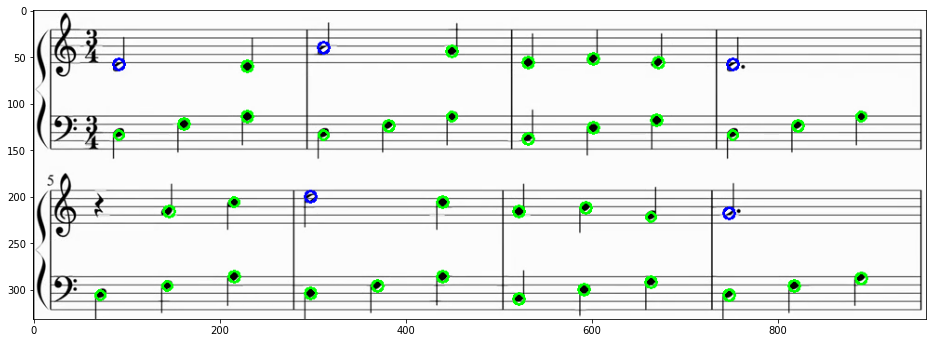

In [22]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
black_circles = get_black_notes(img)
white_circles = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7)
all_circles, black_circles, white_circles = all_notes_circles(img, black_circles, white_circles, min_dist=10, show=True)

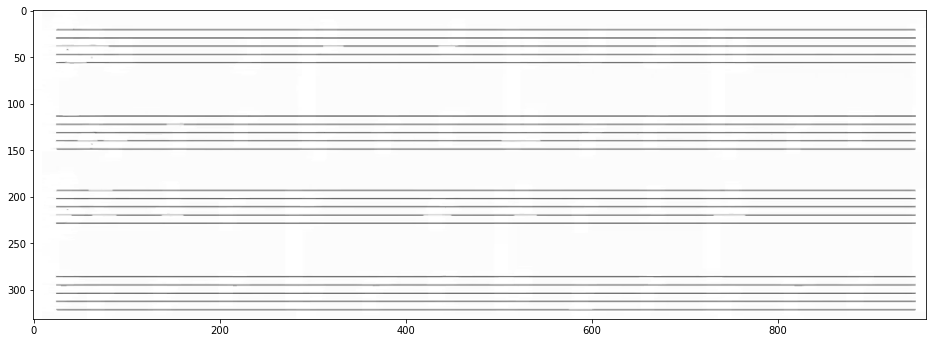

In [23]:
lines_staff = dilate_img(img, kernel_size_x=1, kernel_size_y=15, iterations=1, show = True)

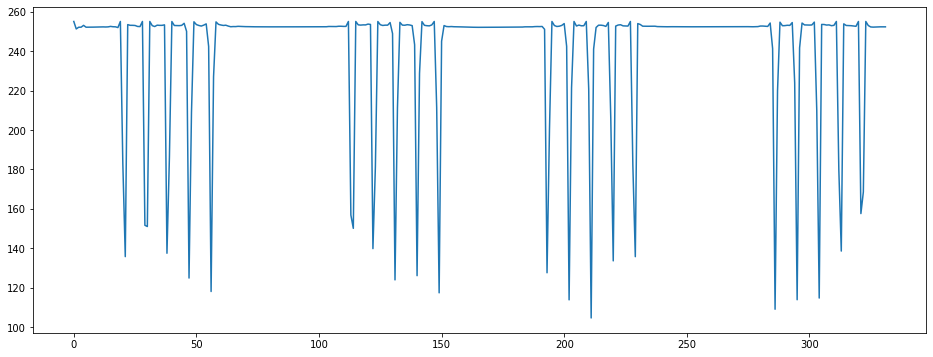

In [24]:
# we want to find the y coordinates of the lines of the staff
y_mean = np.mean(lines_staff, axis=2)
y_mean = np.mean(y_mean, axis=1)
plt.figure(figsize=(16,6))
plt.plot(y_mean)
plt.show()

In [25]:
# index of the lines of the staff are where the y_mean is less 200
index_lines_staff = np.where(y_mean < 200)[0]
index_lines_staff

array([ 20,  21,  29,  30,  38,  39,  47,  56, 113, 114, 122, 123, 131,
       140, 149, 193, 202, 211, 220, 228, 229, 286, 295, 304, 312, 313,
       321, 322])

In [26]:
def isolate_index(index_lines_staff):
    group_staff = []
    for index in index_lines_staff:
        group = {index + 9*i for i in range(5)}
        if group.issubset(index_lines_staff):
            group_staff.append(sorted(list(group)))
    return group_staff

group_staff = isolate_index(index_lines_staff)
group_staff

[[20, 29, 38, 47, 56],
 [113, 122, 131, 140, 149],
 [193, 202, 211, 220, 229],
 [286, 295, 304, 313, 322]]

## Find notes from staff

In [27]:
# there are 4 groups of lines of the staff
# we want to associate each circle to a group of lines of the staff
def group_circles_staff(circles,group_staff):
    circles_group_staff = [[] for _ in range(len(group_staff))]
    for i in range(len(circles[0])):
        circle = circles[0,i]
        dist = [np.abs(circle[1] - group[2]) for group in group_staff]
        circles_group_staff[np.argmin(dist)].append(circle)
    for i in range(len(circles_group_staff)):
        circles_group_staff[i] = sorted(circles_group_staff[i], key=lambda x: x[0])
    return circles_group_staff

circles_group_staff = group_circles_staff(all_circles, group_staff)

In [28]:
circles_group_staff[1]

[array([ 92, 134,   5], dtype=uint16),
 array([162, 122,   6], dtype=uint16),
 array([230, 114,   6], dtype=uint16),
 array([312, 134,   5], dtype=uint16),
 array([382, 124,   6], dtype=uint16),
 array([450, 114,   5], dtype=uint16),
 array([532, 138,   6], dtype=uint16),
 array([602, 126,   6], dtype=uint16),
 array([670, 118,   6], dtype=uint16),
 array([752, 134,   5], dtype=uint16),
 array([822, 124,   6], dtype=uint16),
 array([890, 114,   5], dtype=uint16)]

In [29]:
def get_interline(lines):
    # Compute the average interline
    interline = round(np.mean([lines[i + 1] - lines[i] for i in range(len(lines) - 1)]))
    return interline

def get_base_notes_coordinates(lines):
    # Take the lines and the middles
    base_notes_coordinates = lines.copy()
    interline = get_interline(lines)
    base_notes_coordinates.append(lines[-1] + interline / 2)
    for i in range(1, len(lines)):
        base_notes_coordinates.append(int((lines[i] + lines[i - 1]) / 2))
    base_notes_coordinates.sort()
    return base_notes_coordinates

def get_dic(base_notes_coordinates, clef_de_sol):
    # Associate the name according to the coordinates
    notes_clef_de_sol = ['ré4', 'mi4', 'fa4', 'sol4', 'la4', 'si4', 'do5', 'ré5', 'mi5', 'fa5'][::-1]
    notes_clef_de_fa = ['fa2', 'sol2', 'la2', 'si2', 'do3', 'ré3', 'mi3', 'fa3', 'sol3', 'la3'][::-1]
    dic_int_to_note = {}
    for i in range(len(notes_clef_de_sol)):
        if clef_de_sol:
            dic_int_to_note[base_notes_coordinates[i]] = notes_clef_de_sol[i]
        else:
            dic_int_to_note[base_notes_coordinates[i]] = notes_clef_de_fa[i]
    return dic_int_to_note

def get_notes_names(notes_coordinates, base_notes_coordinates, dic_int_to_note):
    # Attribute the closest note to each
    
    def closest_note(note):
        return base_notes_coordinates[np.array(abs(base_notes_coordinates - note[1])).argmin()]

    notes_names = []
    for note in notes_coordinates:
        notes_names.append(dic_int_to_note.get(closest_note(note)))
        
    return(notes_names)

In [30]:
print(get_notes_names(circles_group_staff[1], get_base_notes_coordinates(group_staff[1]), get_dic(get_base_notes_coordinates(group_staff[1]), False)))

['do3', 'fa3', 'la3', 'do3', 'fa3', 'la3', 'si2', 'mi3', 'sol3', 'do3', 'fa3', 'la3']


## Refining the position of notes

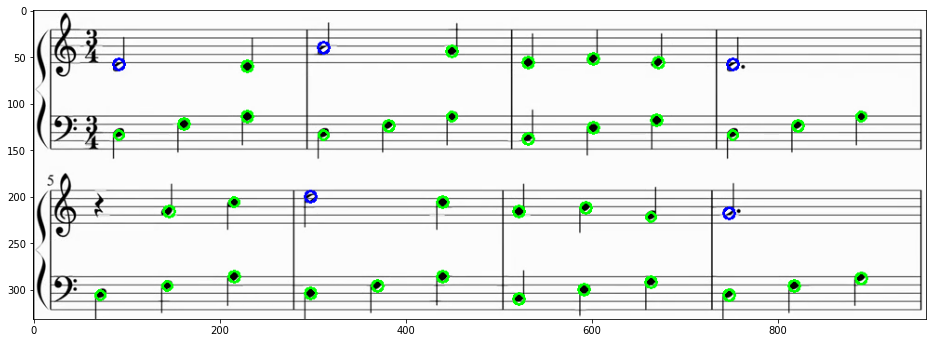

In [31]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
black_circles = get_black_notes(img)
white_circles = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7)
all_circles, black_circles, white_circles = all_notes_circles(img, black_circles, white_circles, min_dist=10, show=True)

### Center of black notes

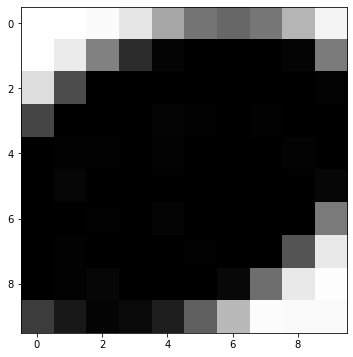

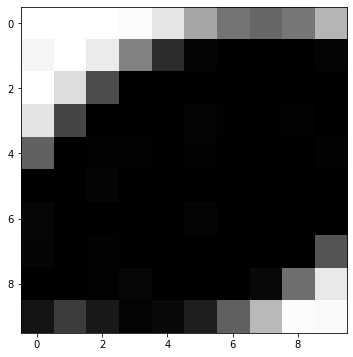

(297, 304)

In [32]:
def find_real_center(img, center, show=False):
    # Find the real center of the note by looking at the pixels around the center
    x, y = center
    # with a sliding window of size 10, we want the crop image to be as black as possible
    # we will use the squared sum of the pixels

    sum_pixels = np.sum(img[y-5:y+5, x-5:x+5])
    for a in range(x-10, x+10):
        for b in range(y-10, y+10):
            if a < 0 or b < 0 or a >= img.shape[1] or b >= img.shape[0]:
                continue
            sum_pixels_new = np.sum(img[b-5:b+5, a-5:a+5])
            if sum_pixels_new < sum_pixels:
                sum_pixels = sum_pixels_new
                x, y = a, b
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(img[center[1]-5:center[1]+5, center[0]-5:center[0]+5])
        plt.show()
        plt.figure(figsize=(16,6))
        plt.imshow(img[y-5:y+5, x-5:x+5])
        plt.show()
    return x, y

find_real_center(img, (black_circles[0][0][0], black_circles[0][0][1]), show=True)


In [33]:
black_circles_center = []
for circle in black_circles[0]:
    black_circles_center.append(find_real_center(img, (circle[0], circle[1])))
black_circles_center = np.array([black_circles_center])

In [34]:
group_black_circles_center = group_circles_staff(black_circles_center, group_staff)

In [35]:
print(get_notes_names(group_black_circles_center[0], get_base_notes_coordinates(group_staff[0]), get_dic(get_base_notes_coordinates(group_staff[0]), True)))
print(get_notes_names(group_black_circles_center[1], get_base_notes_coordinates(group_staff[1]), get_dic(get_base_notes_coordinates(group_staff[1]), False)))
print(get_notes_names(group_black_circles_center[2], get_base_notes_coordinates(group_staff[2]), get_dic(get_base_notes_coordinates(group_staff[2]), True)))
print(get_notes_names(group_black_circles_center[3], get_base_notes_coordinates(group_staff[3]), get_dic(get_base_notes_coordinates(group_staff[3]), False)))


['ré4', 'la4', 'mi4', 'fa4', 'mi4']
['ré3', 'fa3', 'la3', 'ré3', 'fa3', 'la3', 'do3', 'mi3', 'sol3', 'ré3', 'fa3', 'la3']
['la4', 'do5', 'do5', 'la4', 'si4', 'sol4']
['ré3', 'fa3', 'la3', 'ré3', 'fa3', 'la3', 'do3', 'mi3', 'sol3', 'ré3', 'fa3', 'la3']


### Center of white notes

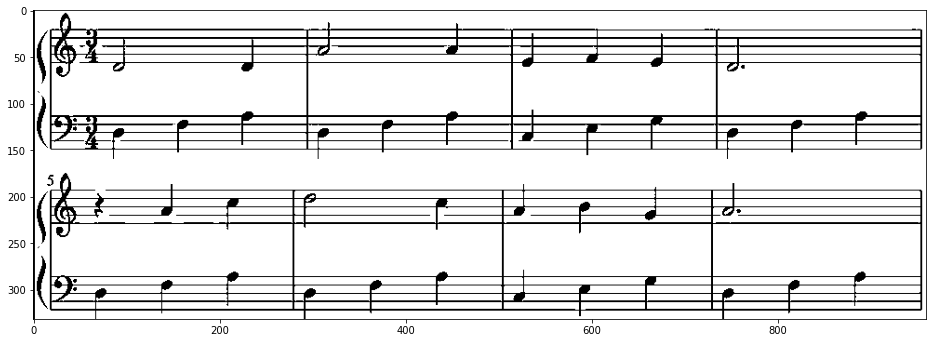

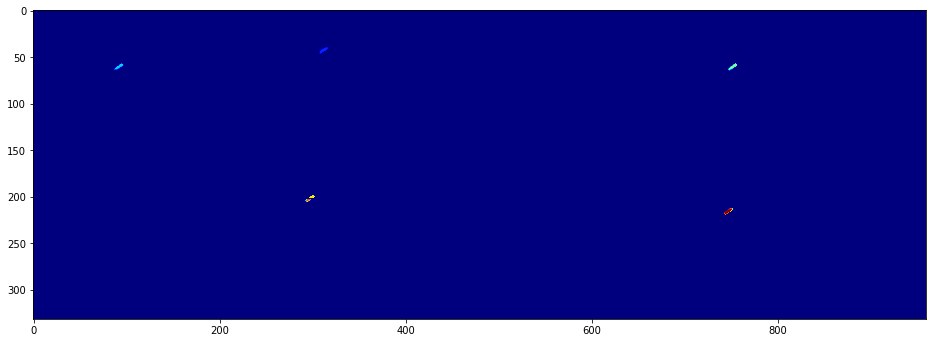

In [36]:
# to find white notes, we should use connected components

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray[img_gray < 180] = 0
img_gray[img_gray >= 180] = 255
plt.figure(figsize=(16,6))
plt.imshow(img_gray, cmap='gray')
plt.show()
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_gray)
for i in range(1, nb_components):
    if stats[i][4] > 40 or centroids[i][0] < 67:  # remove too big components and those that are too close to the left border
        output[output == i] = 0
output[output > 0] = 255
output = output.astype(np.uint8)
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(output)
plt.figure(figsize=(16,6))
plt.imshow(output, cmap='jet')
plt.show()

In [37]:
# when two components are close, we want to get the center of the two components (ponderated by the size of the component)

def get_white_notes_coordinates(nb_components, output, stats, centroids):
    white_notes_coordinates = []
    for i in range(1, nb_components):
        for j in range(1, nb_components):
            if np.linalg.norm(centroids[i] - centroids[j]) < 20 and i != j:
                white_notes_coordinates.append((int((centroids[i][0] * stats[i][4] + centroids[j][0] * stats[j][4]) / (stats[i][4] + stats[j][4])), int((centroids[i][1] * stats[i][4] + centroids[j][1] * stats[j][4]) / (stats[i][4] + stats[j][4]))))
                break
        else:
            white_notes_coordinates.append((int(centroids[i][0]), int(centroids[i][1])))
    return np.array([list(set(white_notes_coordinates))])

white_notes_coordinates = get_white_notes_coordinates(nb_components, output, stats, centroids)

In [38]:
group_white_circles_center = group_circles_staff(white_notes_coordinates, group_staff)

In [39]:
print(get_notes_names(group_white_circles_center[0], get_base_notes_coordinates(group_staff[0]), get_dic(get_base_notes_coordinates(group_staff[0]), True)))
print(get_notes_names(group_white_circles_center[2], get_base_notes_coordinates(group_staff[2]), get_dic(get_base_notes_coordinates(group_staff[2]), True)))

['ré4', 'la4', 'ré4']
['ré5', 'la4']


## Combine everything

In [40]:
def dilate_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(dilation)
        plt.show()
    return dilation

def erode_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    erosion = cv2.erode(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(erosion)
        plt.show()
    return erosion

def get_black_notes(img, show = False):

    dilated = dilate_img(img, 8, 6, show = False)
    eroded = erode_img(dilated, 8, 6, show = False)

    gray = np.float32(cv2.cvtColor(eroded,cv2.COLOR_BGR2GRAY))

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel / sobel.max()*255).astype(np.uint8)

    black_white_threshold = 50
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255

    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 15, param1 = 1, param2 = 6,
                                minRadius = 5,
                                maxRadius = 7
                            )
    circles = np.uint16(np.around(circles))
    new_circles = [] 

    img_circles = img.copy()
    for i in range(len(circles[0,:])):
        if circles[0,i][0] > 70 and circles[0,i][0] < 940: # remove circles too close to the left and right border
            cv2.circle(img_circles, (circles[0,i,0], circles[0,i,1]), circles[0,i,2], (0,255,0), 2)
            new_circles.append(circles[0,i])
        
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.show()

    return np.array([new_circles])

def get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show = False):

    gray = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    inverse = 255 - gray

    circles = cv2.HoughCircles(inverse, cv2.HOUGH_GRADIENT, dp = dp, minDist = minDist, param1 = param1, param2 = param2,
                                minRadius = minRadius,
                                maxRadius = maxRadius
                            )
    circles = np.uint16(np.around(circles))
    new_circles = [] 

    img_circles = img.copy()
    for i in range(len(circles[0,:])):
        if circles[0,i][0] > 70 and circles[0,i][0] < 940: # remove circles too close to the left and right border
            if max(img[circles[0,i][1]+x, circles[0,i][0]+j, 0] for x in range(-1,2) for j in range(-1,2)) > 200: # if the center of the circle is not black
                cv2.circle(img_circles,(circles[0,i][0],circles[0,i][1]),circles[0,i][2],(0,255,0),2)
                new_circles.append(circles[0,i])

    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.show()

    return np.array([new_circles])

def min_distance(center, circles):
    if len(circles) == 0:
        return 1000000
    return min(np.sqrt((center[0].astype(int) - circles[:,0].astype(int))**2 + (center[1].astype(int) - circles[:,1].astype(int))**2))

def all_notes_circles(img, black_circles, white_circles, min_dist=20, show=False):
    new_white_circles = []
    for i in range(len(white_circles[0])):
        white_circle = white_circles[0,i]
        if min_distance(white_circle, black_circles[0]) > min_dist and min_distance(white_circle, white_circles[0,i+1:]) > min_dist:
            new_white_circles.append(white_circle)
    new_white_circles = np.array([new_white_circles])
    if show:
        img_circles = img.copy()
        for i in new_white_circles[0,:]:
            cv2.circle(img_circles,(i[0],i[1]),i[2],(0,0,255),2)
        for i in black_circles[0,:]:
            cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.show()
    all_circles = np.concatenate((black_circles, new_white_circles), axis=1)
    return all_circles, black_circles, new_white_circles

def isolate_index(index_lines_staff):
    group_staff = []
    for index in index_lines_staff:
        group = {index + 9*i for i in range(5)}
        if group.issubset(index_lines_staff):
            group_staff.append(sorted(list(group)))
    return group_staff

def group_circles_staff(circles,group_staff):
    circles_group_staff = [[] for _ in range(len(group_staff))]
    for i in range(len(circles[0])):
        circle = circles[0,i]
        dist = [np.abs(circle[1] - group[2]) for group in group_staff]
        circles_group_staff[np.argmin(dist)].append(circle)
    for i in range(len(circles_group_staff)):
        circles_group_staff[i] = sorted(circles_group_staff[i], key=lambda x: x[0])
    return circles_group_staff

def find_real_black_center(img, center, show=False):
    x, y = center
    sum_pixels = np.sum(img[y-5:y+5, x-5:x+5])
    for a in range(x-10, x+10):
        for b in range(y-10, y+10):
            if a < 0 or b < 0 or a >= img.shape[1] or b >= img.shape[0]:
                continue
            sum_pixels_new = np.sum(img[b-5:b+5, a-5:a+5])
            if sum_pixels_new < sum_pixels:
                sum_pixels = sum_pixels_new
                x, y = a, b
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(img[y-5:y+5, x-5:x+5])
        plt.show()
    return x, y

def find_small_components(img, show=False):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray[img_gray < 180] = 0
    img_gray[img_gray >= 180] = 255
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_gray)
    for i in range(1, nb_components):
        if stats[i][4] > 40 or centroids[i][0] < 67 or centroids[i][0] > 940:  # remove too big components and those that are too close to the left and right border
            output[output == i] = 0
    output[output > 0] = 255
    output = output.astype(np.uint8)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(output)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(output, cmap='jet')
        plt.show()
    return nb_components, output, stats, centroids

def find_real_white_center(nb_components, stats, centroids):
    white_notes_coordinates = []
    for i in range(1, nb_components):
        for j in range(1, nb_components):
            if np.linalg.norm(centroids[i] - centroids[j]) < 20 and i != j:
                white_notes_coordinates.append((int((centroids[i][0] * stats[i][4] + centroids[j][0] * stats[j][4]) / (stats[i][4] + stats[j][4])), int((centroids[i][1] * stats[i][4] + centroids[j][1] * stats[j][4]) / (stats[i][4] + stats[j][4]))))
                break
        else:
            white_notes_coordinates.append((int(centroids[i][0]), int(centroids[i][1])))
    return np.array([list(set(white_notes_coordinates))])

In [41]:
def get_interline(lines):
    # Compute the average interline
    interline = round(np.mean([lines[i + 1] - lines[i] for i in range(len(lines) - 1)]))
    return interline

def get_base_notes_coordinates(lines):
    # Take the lines and the middles
    base_notes_coordinates = lines.copy()
    interline = get_interline(lines)
    base_notes_coordinates.append(lines[-1] + interline)
    base_notes_coordinates.append(lines[-1] + interline / 2)
    base_notes_coordinates.append(lines[0] - interline)
    base_notes_coordinates.append(lines[0] - interline / 2)
    for i in range(1, len(lines)):
        base_notes_coordinates.append(int((lines[i] + lines[i - 1]) / 2))
    base_notes_coordinates.sort()
    return base_notes_coordinates

def get_dic(base_notes_coordinates, clef_de_sol):
    # Associate the name according to the coordinates
    notes_clef_de_sol = ['do4', 'ré4', 'mi4', 'fa4', 'sol4', 'la4', 'si4', 'do5', 'ré5', 'mi5', 'fa5', 'sol5', 'la5'][::-1]
    notes_clef_de_fa = ['mi2', 'fa2', 'sol2', 'la2', 'si2', 'do3', 'ré3', 'mi3', 'fa3', 'sol3', 'la3', 'si3', 'do4'][::-1]
    dic_int_to_note = {}
    for i in range(len(notes_clef_de_sol)):
        if clef_de_sol:
            dic_int_to_note[base_notes_coordinates[i]] = notes_clef_de_sol[i]
        else:
            dic_int_to_note[base_notes_coordinates[i]] = notes_clef_de_fa[i]
    return dic_int_to_note

def get_notes_names(notes_coordinates, base_notes_coordinates, dic_int_to_note):
    # Attribute the closest note to each
    
    def closest_note(note):
        return base_notes_coordinates[np.array(abs(base_notes_coordinates - note[1])).argmin()]

    notes_names = []
    for note in notes_coordinates:
        notes_names.append(dic_int_to_note.get(closest_note(note)))
        
    return(notes_names)

In [42]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
lines_staff = dilate_img(img, kernel_size_x=1, kernel_size_y=15, iterations=1, show = False)
y_mean =  np.mean(np.mean(lines_staff, axis=2), axis=1)
index_lines_staff = np.where(y_mean < 200)[0]
group_staff = isolate_index(index_lines_staff)

In [43]:
def pipeline_notes_staff(img, img2=None, show=False):
    black_circles = get_black_notes(img, show = show)
    if img2 is None:
        white_circles = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show = show)
    else:
        white_circles1 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=6, minRadius=6, maxRadius=7, show = show)
        white_circles2 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show = show)
        white_circles = np.concatenate((white_circles1, white_circles2), axis=1)
    
    _, black_circles, white_circles = all_notes_circles(img, black_circles, white_circles, min_dist=30, show=False)

    black_circles_center = []
    for circle in black_circles[0]:
        black_circles_center.append(find_real_black_center(img, (circle[0], circle[1])))
    black_circles_center = np.array([black_circles_center])
    group_black_circles_center = group_circles_staff(black_circles_center, group_staff)

    nb_components, output, stats, centroids = find_small_components(img, show=False)
    white_circles_center = find_real_white_center(nb_components, stats, centroids)
    group_white_circles_center = group_circles_staff(white_circles_center, group_staff)

    group_circles_center = []
    for i in range(len(group_staff)):
        group_circles_center.append(sorted(group_black_circles_center[i] + group_white_circles_center[i], key=lambda x: x[0]))
    
    return group_circles_center

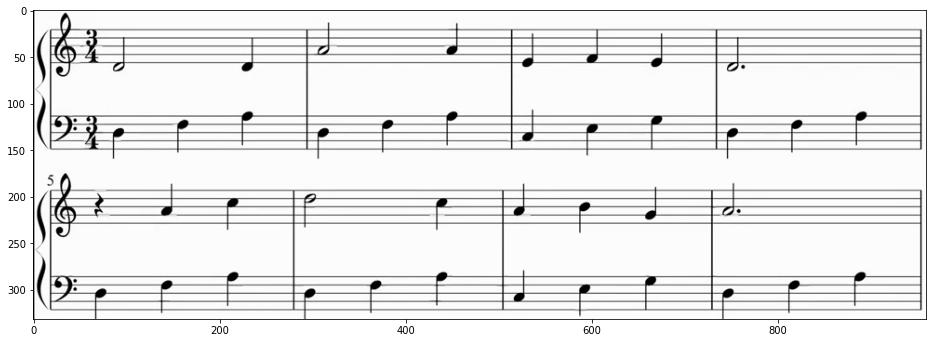

In [44]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)

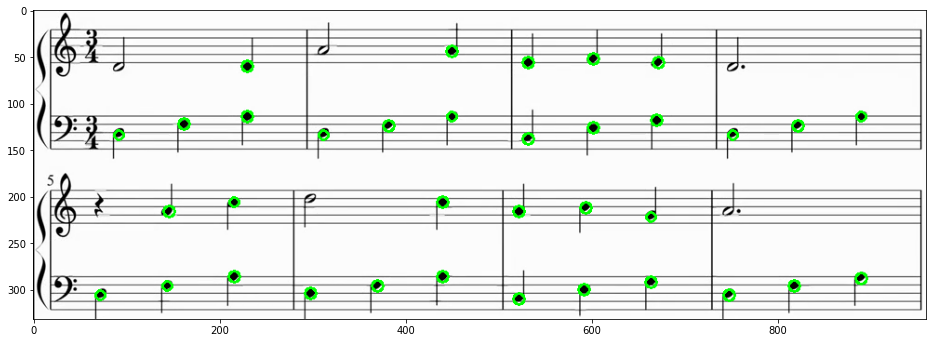

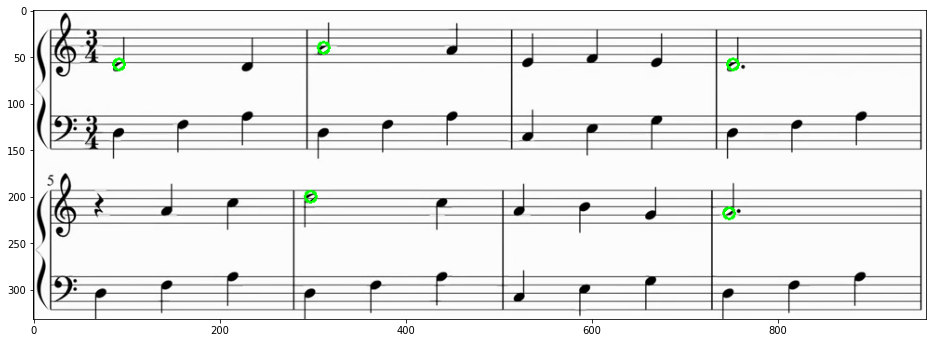

In [45]:
group_circles_center = pipeline_notes_staff(img, show=True)

In [46]:
def circles_to_notes_names(group_circles_center, group_staff):
    notes_names = []
    for i in range(len(group_staff)):
        notes_names.append(get_notes_names(group_circles_center[i], get_base_notes_coordinates(group_staff[i]), get_dic(get_base_notes_coordinates(group_staff[i]), (i % 2 == 0))))
    return notes_names

print(circles_to_notes_names(group_circles_center, group_staff))


[['ré4', 'ré4', 'la4', 'la4', 'mi4', 'fa4', 'mi4', 'ré4'], ['ré3', 'fa3', 'la3', 'ré3', 'fa3', 'la3', 'do3', 'mi3', 'sol3', 'ré3', 'fa3', 'la3'], ['la4', 'do5', 'ré5', 'do5', 'la4', 'si4', 'sol4', 'la4'], ['ré3', 'fa3', 'la3', 'ré3', 'fa3', 'la3', 'do3', 'mi3', 'sol3', 'ré3', 'fa3', 'la3']]


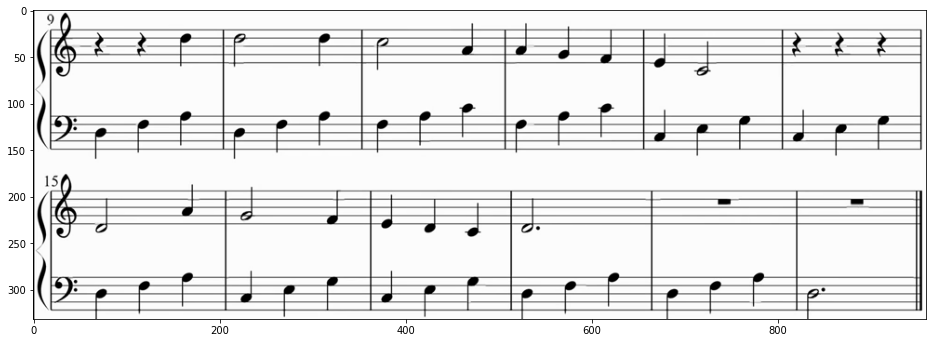

In [47]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

_, frame = bfc.get_frame(cap, 781)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)

_, frame = bfc.get_frame(cap, 677)
img2 = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)

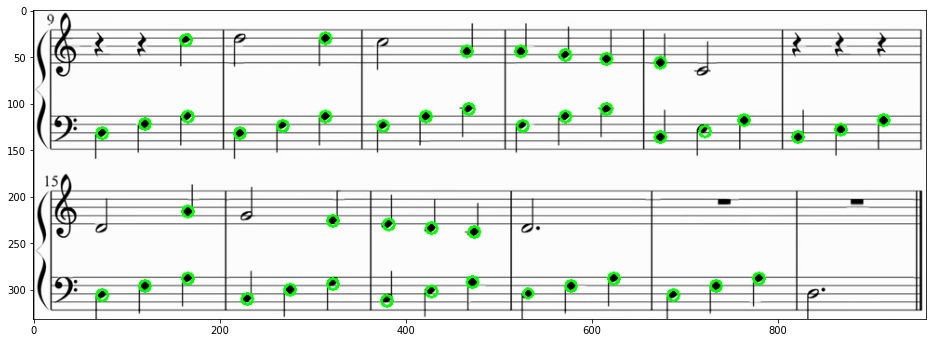

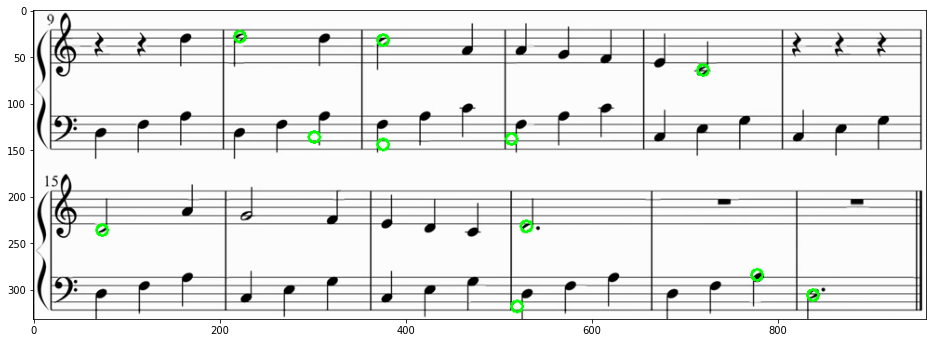

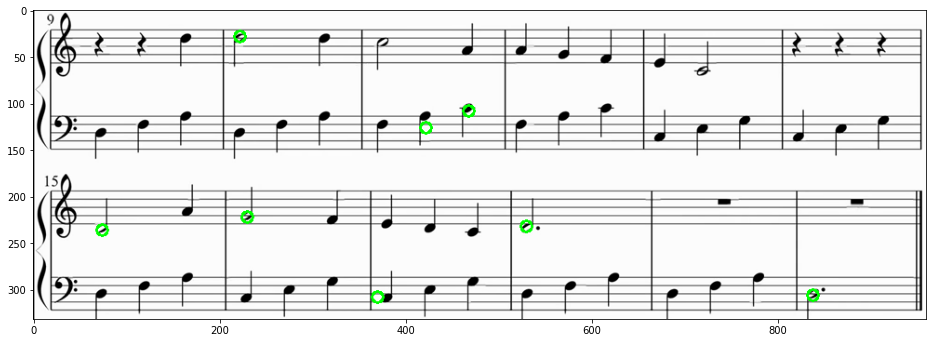

In [48]:
group_circles_center = pipeline_notes_staff(img, img2, show=True)

In [49]:
for i in range(len(group_staff)): # group_black_circles_center, group_white_circles_center
    print(get_notes_names(group_circles_center[i], get_base_notes_coordinates(group_staff[i]), get_dic(get_base_notes_coordinates(group_staff[i]), (i % 2 == 0))))

['ré5', 'ré5', 'ré5', 'do5', 'la4', 'la4', 'sol4', 'fa4', 'mi4', 'do4']
['ré3', 'fa3', 'la3', 'ré3', 'fa3', 'la3', 'fa3', 'la3', 'do4', 'fa3', 'la3', 'do4', 'do3', 'mi3', 'sol3', 'do3', 'mi3', 'sol3']
['ré4', 'la4', 'sol4', 'fa4', 'mi4', 'ré4', 'do4', 'ré4']
['ré3', 'fa3', 'la3', 'do3', 'mi3', 'sol3', 'do3', 'mi3', 'sol3', 'ré3', 'fa3', 'la3', 'ré3', 'fa3', 'la3', 'ré3']


# Now the tempo

## Nombre de mesures

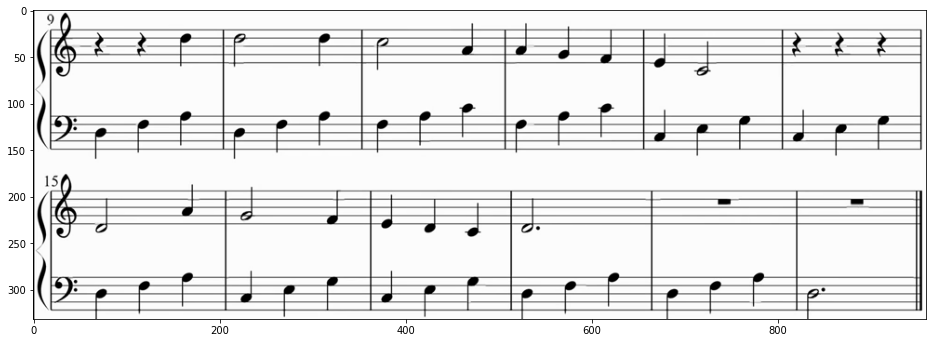

In [50]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 677) # 10,677, 781
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)

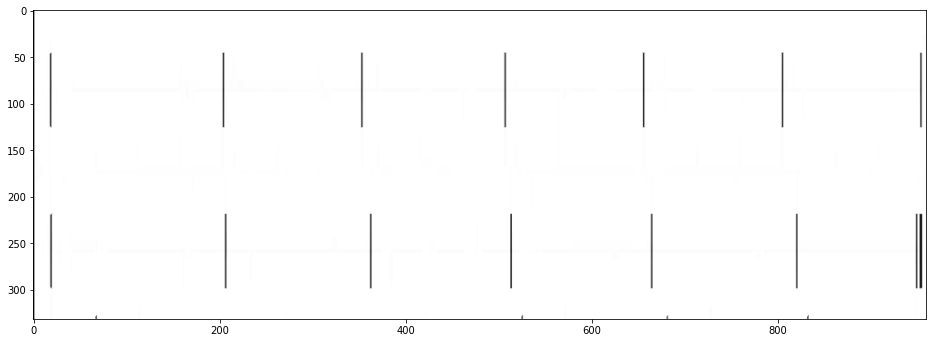

In [51]:
dilated_img = dilate_img(img, kernel_size_x=50, kernel_size_y=1, iterations=1, show = True)

In [52]:
x_mean1 =  np.mean(np.mean(dilated_img[:175,], axis=2), axis=0) # first two staff
index_mesure1 = [x for x in np.where(x_mean1 < 200)[0] if 30 < x < 940]
x_mean2 =  np.mean(np.mean(dilated_img[175:,], axis=2), axis=0) # third and fourth staff
index_mesure2 = [x for x in np.where(x_mean2 < 200)[0] if 30 < x < 940]
# sometimes, x and x+1 are both < 200, so we need to remove the duplicates 
index_mesure1 = [x for x in index_mesure1 if x+1 not in index_mesure1]
index_mesure2 = [x for x in index_mesure2 if x+1 not in index_mesure2]
index_mesure1, index_mesure2

([204, 353, 507, 656, 805], [207, 363, 514, 665, 821])

In [53]:
def pipeline_number_mesure(img, show=False):
    dilated_img = dilate_img(img, kernel_size_x=50, kernel_size_y=1, iterations=1, show = show)
    x_mean1 =  np.mean(np.mean(dilated_img[:175,], axis=2), axis=0) # first two staff
    index_mesure1 = [x for x in np.where(x_mean1 < 200)[0] if 30 < x < 940]
    x_mean2 =  np.mean(np.mean(dilated_img[175:,], axis=2), axis=0) # third and fourth staff
    index_mesure2 = [x for x in np.where(x_mean2 < 200)[0] if 30 < x < 940]
    # sometimes, x and x+1 are both < 200, so we need to remove the duplicates 
    index_mesure1 = [x for x in index_mesure1 if x+1 not in index_mesure1]
    index_mesure2 = [x for x in index_mesure2 if x+1 not in index_mesure2]
    return [40]+index_mesure1+[940], [40]+index_mesure2+[940] # 30 and 940 are the left and right border of the image

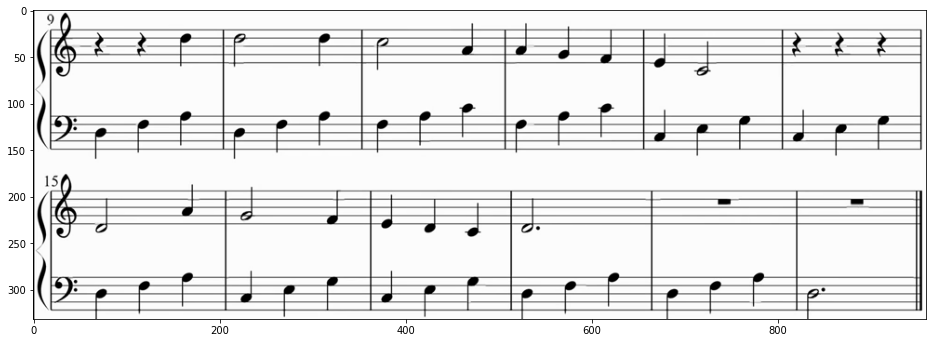

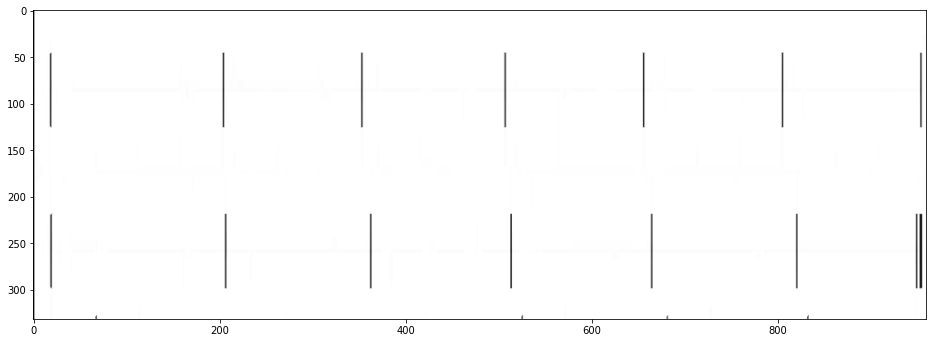

In [54]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 677) # 10,677, 781
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)
index_mesure1, index_mesure2 = pipeline_number_mesure(img, show=True)

In [55]:
def highlight_beat(img, mesure, beat, index_mesure, group_staff): # group_staff = [group_staff1, group_staff2]
    # we hightlight the zone between the two points of t
    new_img = img.copy()
    y_min, y_max = group_staff[0][0] - 20, group_staff[1][-1] + 20
    length_mesure = index_mesure[mesure] - index_mesure[mesure-1] - 10
    x_min = int(index_mesure[mesure-1] + length_mesure * (beat-1) / 3)
    x_max = int(x_min + length_mesure / 3)
    new_img[y_min:y_max, x_min:x_max, 0] = 0
    new_img[y_min:y_max, x_min:x_max, 2] = 0
    plt.figure(figsize=(16, 10))
    plt.imshow(new_img)
    plt.show()

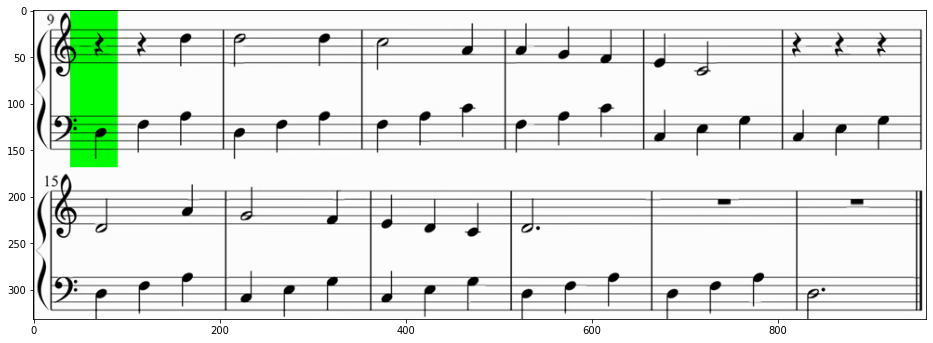

In [56]:
highlight_beat(img, 1, 1, index_mesure1, group_staff)

## Locations of notes

In [57]:
# we want to know where the notes are (which measure and wich staff and especially at what beat (here, 3/4 is the time signature))

cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 781) # 10,677, 781
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_, frame = bfc.get_frame(cap, 677)
img2 = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
group_circles_center = pipeline_notes_staff(img, img2, show=False)
index_mesure1, index_mesure2 = pipeline_number_mesure(img, show=False)

In [58]:
def transform_to_beat(group_circles_center, index_mesure1, index_mesure2):
    group_beat = []
    for i in range(len(group_circles_center)):
        group_beat_i = []
        for j in range(len(group_circles_center[i])):
            mesures = index_mesure1 if i < 2 else index_mesure2
            for k in range(1, len(mesures)):
                if mesures[k-1] <= group_circles_center[i][j][0] < mesures[k]:
                    mesure = k
                    if mesures[k-1] <= group_circles_center[i][j][0] < mesures[k-1]+(mesures[k]-mesures[k-1])/3:
                        beat = 1
                    elif mesures[k-1]+(mesures[k]-mesures[k-1])/3 <= group_circles_center[i][j][0] < mesures[k-1]+2*(mesures[k]-mesures[k-1])/3:
                        beat = 2
                    else:
                        beat = 3
                    group_beat_i.append([mesure, beat])
                    break
        group_beat.append(group_beat_i)
    return group_beat

In [59]:
group_beat = transform_to_beat(group_circles_center, index_mesure1, index_mesure2)

# EACH BEAT SHEET AND PIANO

In [60]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

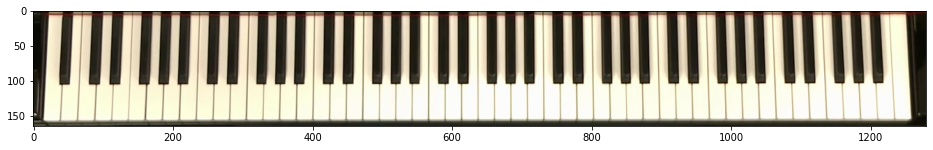

In [61]:
piano = bfc.get_frame(cap, 814)[1]
piano = bfc.crop_frame(piano, 375, 0, 540-375, piano.shape[1], show=True)

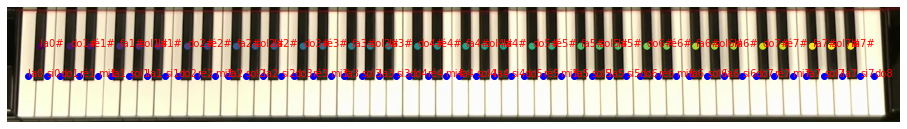

In [62]:
pipe = pkn.pipeline(piano, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=[0,0,0,0,0,0,1])
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

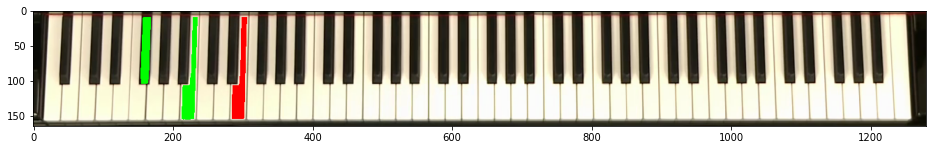

In [63]:
g = [0,255,0]
b = [0,0,255]
r = [255,0,0]
_ = pkn.highlight_keys(image=piano, labels=labels, keys = [10,15,20], color = [g,g,r], show=True)

In [64]:
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
lines_staff = dilate_img(img, kernel_size_x=1, kernel_size_y=15, iterations=1, show = False)
y_mean =  np.mean(np.mean(lines_staff, axis=2), axis=1)
index_lines_staff = np.where(y_mean < 200)[0]
group_staff = isolate_index(index_lines_staff)

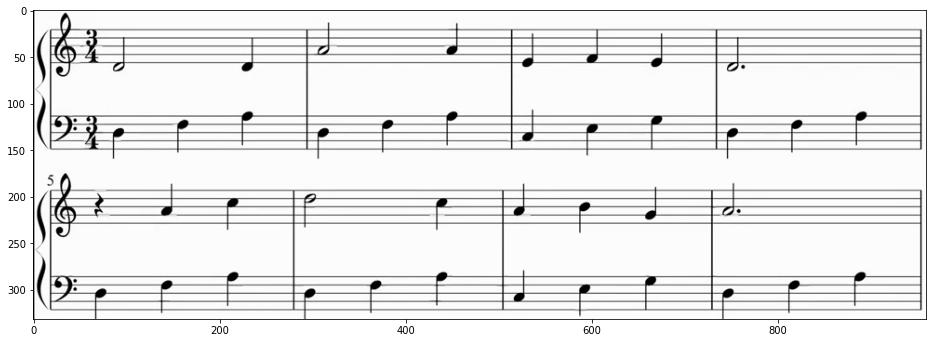

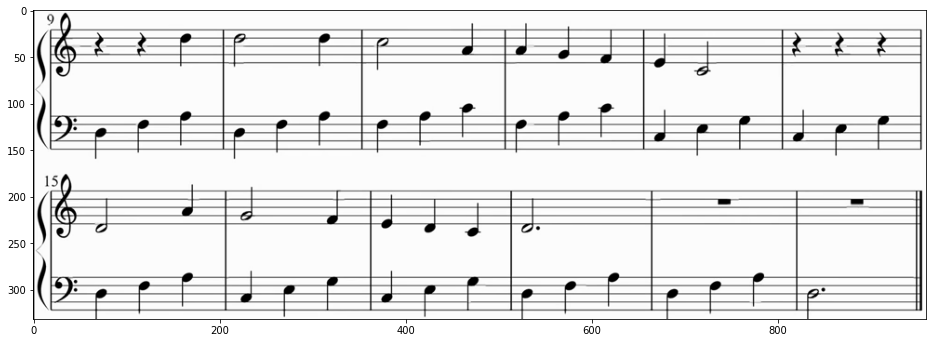

In [65]:
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)
sheet1 = pipeline_notes_staff(img, show=False)
index_mesure1a, index_mesure1b = pipeline_number_mesure(img, show=False)
group_beat1 = transform_to_beat(sheet1, index_mesure1a, index_mesure1b)
note_names1 = circles_to_notes_names(sheet1, group_staff)

_, frame = bfc.get_frame(cap, 781)
img1 = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_, frame = bfc.get_frame(cap, 677)
img2 = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)
sheet2 = pipeline_notes_staff(img1, img2, show=False)
index_mesure2a, index_mesure2b = pipeline_number_mesure(img1, show=False)
group_beat2 = transform_to_beat(sheet2, index_mesure2a, index_mesure2b)
note_names2 = circles_to_notes_names(sheet2, group_staff)

In [66]:
total_mesures = len(index_mesure1a) + len(index_mesure1b) + len(index_mesure2a) + len(index_mesure2b) - 4
total_beats = total_mesures * 3

def beat_to_infos(beat):
    # beat is a number between 1 and total_beats
    if beat <= (len(index_mesure1a)-1) * 3:
        return (beat-1)%3+1, beat-1, index_mesure1a, group_staff[:2], img, group_beat1[:2], note_names1[:2]
    elif beat <= (len(index_mesure1a)-1) * 3 + (len(index_mesure1b)-1) * 3:
        return (beat-1)%3+1, beat-1-(len(index_mesure1a)-1)*3, index_mesure1b, group_staff[2:4], img, group_beat1[2:4], note_names1[2:4]
    elif beat <= (len(index_mesure1a)-1) * 3 + (len(index_mesure1b)-1) * 3 + (len(index_mesure2a)-1) * 3:
        return (beat-1)%3+1, beat-1-(len(index_mesure1a)-1)*3-(len(index_mesure1b)-1)*3, index_mesure2a, group_staff[:2], img1, group_beat2[:2], note_names2[:2]
    else:
        return (beat-1)%3+1, beat-1-(len(index_mesure1a)-1)*3-(len(index_mesure1b)-1)*3-(len(index_mesure2a)-1)*3, index_mesure2b, group_staff[2:4], img2, group_beat2[2:4], note_names2[2:4]
    # return beat in mesure, beat in sheet, index of mesure, group_staff, image, group_beat, note_names

In [67]:
def notes_in_beat(note_names, group_beat, mesure, beat):
    notes = [[],[]]
    for i in range(len(group_beat)):
        for j in range(len(group_beat[i])):
            if group_beat[i][j][0] == mesure and group_beat[i][j][1] == beat:
                notes[1-i].append(note_names[i][j])
    return notes

In [68]:
def show_sheet(beat):
    beat_in_mesure, beat_in_sheet, index_mesure, group_staff, img, group_beat, note_names= beat_to_infos(beat)
    notes_at_beat = notes_in_beat(note_names, group_beat, beat_in_sheet//3+1, beat_in_mesure)
    print(notes_at_beat)
    highlight_beat(img, beat_in_sheet//3+1, beat_in_mesure, index_mesure, group_staff)
    _ = pkn.highlight_notes(image=piano, labels=labels, notes = notes_at_beat[0]+notes_at_beat[1],
                            dict_notes = notes, color = [g,g,r], show=True)
    

interact(show_sheet, beat=(1, total_beats, 1))

interactive(children=(IntSlider(value=30, description='beat', max=60, min=1), Output()), _dom_classes=('widget…

<function __main__.show_sheet(beat)>